# Setup


In [387]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get data

In [388]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = load_breast_cancer()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

# Explore data

In [389]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [390]:
features_list = list(data.feature_names)
target_list = list(data.target_names)

In [391]:
bc_data = pd.DataFrame(data.data[:,:], columns=features)

In [392]:
bc_data = bc_data.apply(pd.to_numeric, errors='coerce')
bc_data = bc_data.dropna()
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

# Split data

In [393]:
X = bc_data
y = pd.Series(data.target)

In [394]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((398, 30), (398,), (171, 30), (171,))

# Feature selection

## Initial correlation matrix

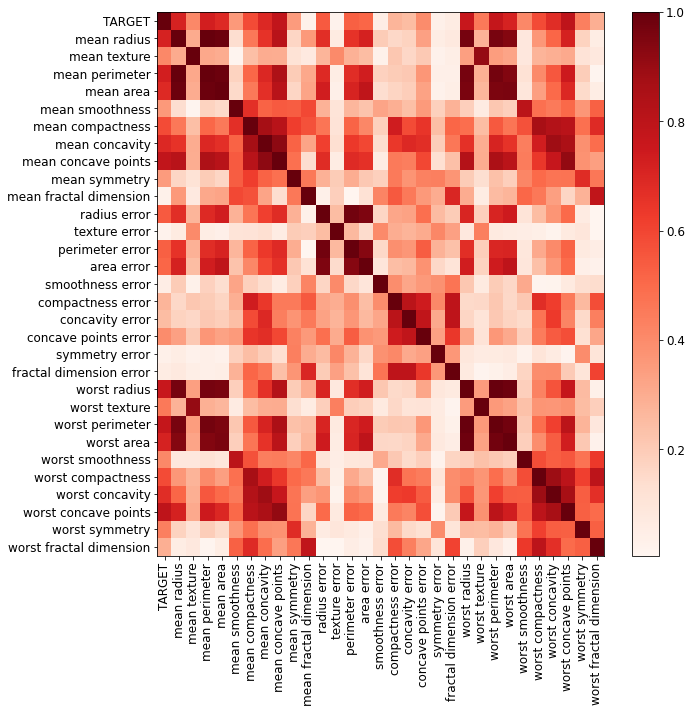

In [395]:
def correlation_matrix(y, X, is_plot=False):
    yX = pd.concat([y, X], axis=1)
    yX = yX.rename(columns={0: 'TARGET'})
    
    yX_corr = yX.corr(method='pearson')
    
    yX_abs_corr = np.abs(yX_corr)
    
    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(yX_abs_corr, cmap='Reds', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
        plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
        plt.show()
    
    return yX, yX_corr, yX_abs_corr

yX, yX_corr, yX_abs_corr = correlation_matrix(y_train, X_train, is_plot=True)  

## Brute force/Hand picked selection

In [396]:
drop_list = ['mean perimeter','mean radius','mean compactness','mean concave points','radius error','perimeter error', 'symmetry error','worst radius','worst perimeter','worst compactness','worst concave points','compactness error','concave points error','worst texture','worst area']
relevant_features = bc_data.drop(drop_list, axis = 1)
relevant_features.head()

,mean texture,mean area,mean smoothness,mean concavity,mean symmetry,mean fractal dimension,texture error,area error,smoothness error,concavity error,fractal dimension error,worst smoothness,worst concavity,worst symmetry,worst fractal dimension
0,10.38,1001.0,0.11840,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,0.05373,0.006193,0.1622,0.7119,0.4601,0.11890
1,17.77,1326.0,0.08474,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,0.01860,0.003532,0.1238,0.2416,0.2750,0.08902
2,21.25,1203.0,0.10960,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,0.03832,0.004571,0.1444,0.4504,0.3613,0.08758
3,20.38,386.1,0.14250,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,0.05661,0.009208,0.2098,0.6869,0.6638,0.17300
4,14.34,1297.0,0.10030,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,0.05688,0.005115,0.1374,0.4000,0.2364,0.07678


In [397]:
X_new = relevant_features
y = pd.Series(data.target)

In [398]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y, test_size=0.3, random_state=42)
X_train2.shape, y_train2.shape,X_test2.shape, y_test2.shape

((398, 15), (398,), (171, 15), (171,))

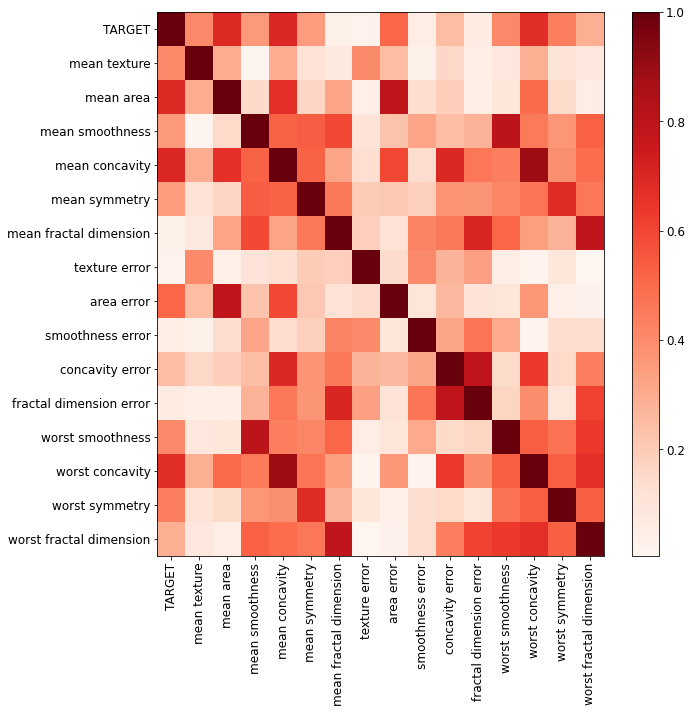

In [399]:
def correlation_matrix(y, X, is_plot=False):
    yX = pd.concat([y, X], axis=1)
    yX = yX.rename(columns={0: 'TARGET'})
    
    yX_corr = yX.corr(method='pearson')
    
    yX_abs_corr = np.abs(yX_corr)
    
    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(yX_abs_corr, cmap='Reds', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
        plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
        plt.show()
    
    return yX, yX_corr, yX_abs_corr

yX, yX_corr, yX_abs_corr = correlation_matrix(y_train2, X_train2, is_plot=True)  

## Decision tree

In [400]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

treeclf = DecisionTreeClassifier()
treeclf.fit(X_train.values, y_train.values)

DecisionTreeClassifier()

In [401]:
treeclf.predict(X_test.values)

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

### Grid search

In [402]:
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1,10),
    'min_samples_leaf' : range(1,6),
    'max_leaf_nodes' : range(2, 10)
}

In [403]:
grid = GridSearchCV(treeclf, 
                    param_grid = parameters,
                    cv=10,
                    verbose=1
                   )
grid.fit(X_train.values, y_train.values)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'max_leaf_nodes': range(2, 10),
                         'min_samples_leaf': range(1, 6)},
             verbose=1)

In [404]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 5}

In [405]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=8,
                       min_samples_leaf=5)

In [406]:
grid.best_score_

0.9421153846153846

### Feature selection with Decision Tree

In [476]:
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=8,
                       min_samples_leaf=5)
tree_clf.fit(X_train.values, y_train.values)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=8,
                       min_samples_leaf=5)

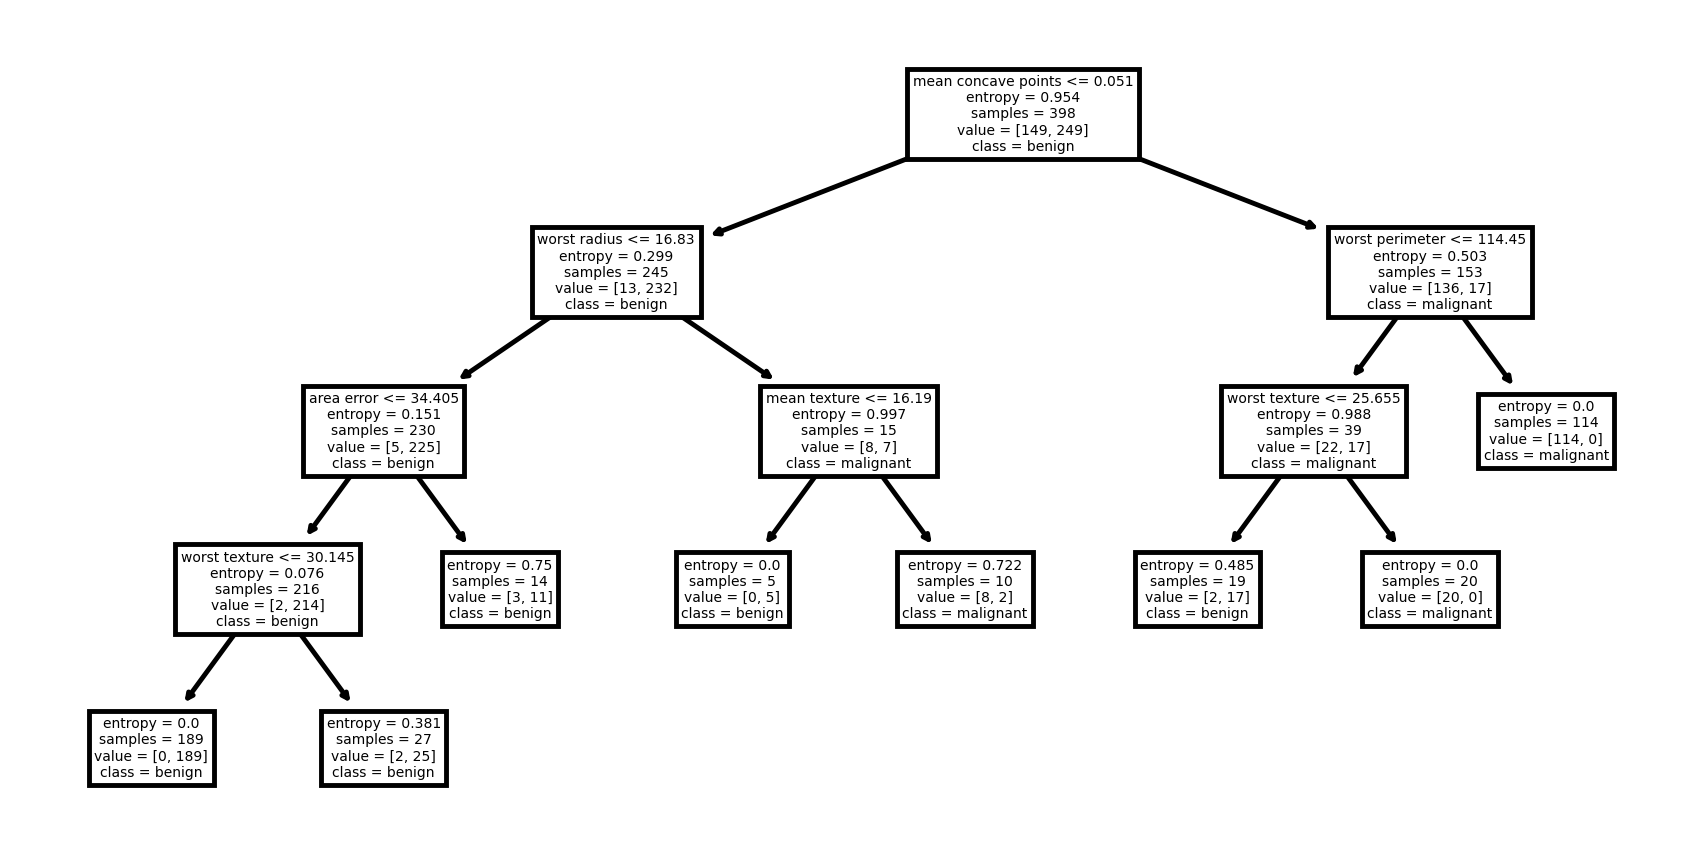

In [477]:
from sklearn import tree 

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,3), dpi=350)

tree.plot_tree(tree_clf,
              feature_names = features_list,
              class_names = target_list)
plt.show()

In [479]:
drop_list = ['mean radius',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean symmetry',
 'mean fractal dimension',
 'texture error',
 'perimeter error',
#  'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst area',
 'worst smoothness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension',
 'worst compactness']
a_features = bc_data.drop(drop_list, axis = 1)
a_features.head()

,mean texture,mean concave points,radius error,area error,worst radius,worst texture,worst perimeter
0,10.38,0.14710,1.0950,153.40,25.38,17.33,184.60
1,17.77,0.07017,0.5435,74.08,24.99,23.41,158.80
2,21.25,0.12790,0.7456,94.03,23.57,25.53,152.50
3,20.38,0.10520,0.4956,27.23,14.91,26.50,98.87
4,14.34,0.10430,0.7572,94.44,22.54,16.67,152.20


### Training the new set of features

In [480]:
X_new2 = a_features
y = pd.Series(data.target)

In [481]:
from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_new2, y, test_size=0.3, random_state=42)
X_train3.shape, y_train3.shape,X_test3.shape, y_test3.shape

((398, 7), (398,), (171, 7), (171,))

In [482]:
from sklearn.model_selection import cross_val_score

cross_val_score(tree_clf, X_train3.values, y_train3.values, cv=3, scoring="accuracy")

array([0.93984962, 0.89473684, 0.9469697 ])

In [483]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_predict = cross_val_predict(tree_clf, X_train3.values, y_train3.values, cv=3)
confusion_matrix(y_train3.values, y_predict)

array([[139,  10],
       [ 18, 231]], dtype=int64)

### Correlation matrix of selected features 

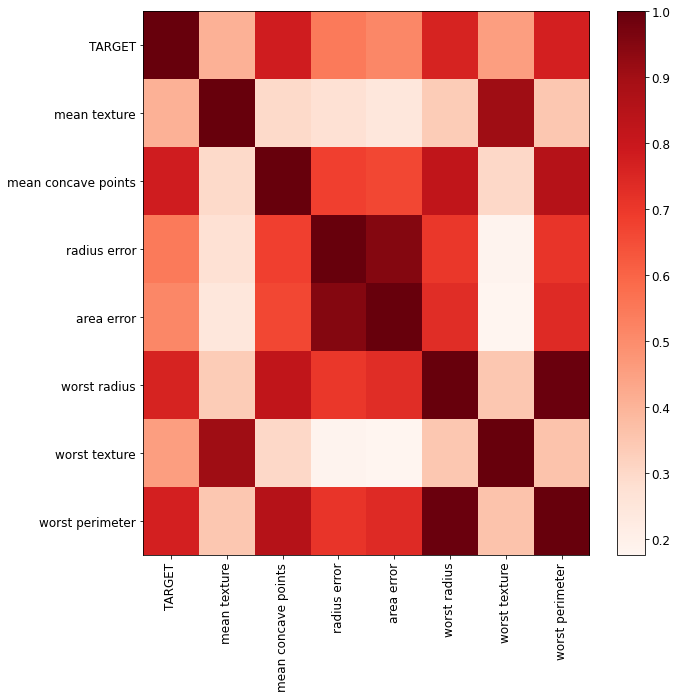

In [484]:
def correlation_matrix(y, X, is_plot=False):
    yX = pd.concat([y, X], axis=1)
    yX = yX.rename(columns={0: 'TARGET'})
    
    yX_corr = yX.corr(method='pearson')
    
    yX_abs_corr = np.abs(yX_corr)
    
    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(yX_abs_corr, cmap='Reds', interpolation='none', aspect='auto')
        plt.colorbar()seven
        plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
        plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
        plt.show()
    
    return yX, yX_corr, yX_abs_corr

yX, yX_corr, yX_abs_corr = correlation_matrix(y_train3, X_train3, is_plot=True)  

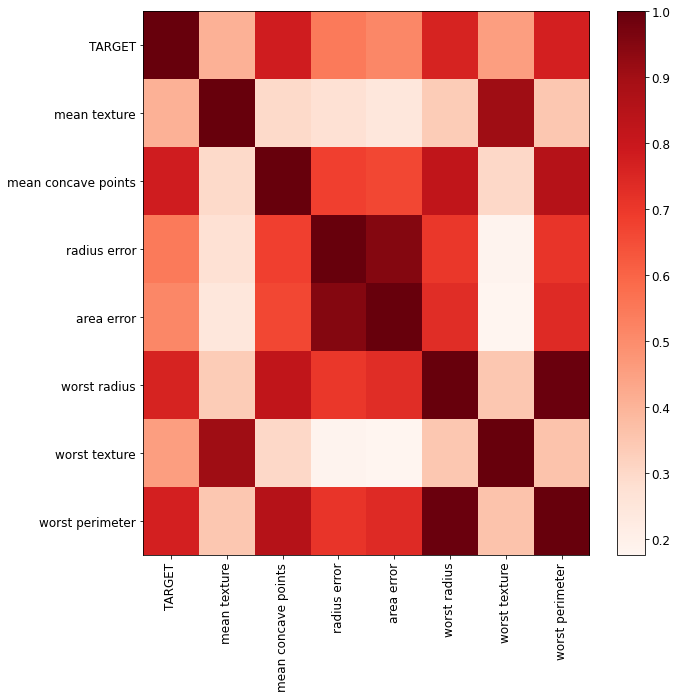

In [484]:
def correlation_matrix(y, X, is_plot=False):
    yX = pd.concat([y, X], axis=1)
    yX = yX.rename(columns={0: 'TARGET'})
    
    yX_corr = yX.corr(method='pearson')
    
    yX_abs_corr = np.abs(yX_corr)
    
    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(yX_abs_corr, cmap='Reds', interpolation='none', aspect='auto')
        plt.colorbar()seven
        plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
        plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
        plt.show()
    
    return yX, yX_corr, yX_abs_corr

yX, yX_corr, yX_abs_corr = correlation_matrix(y_train3, X_train3, is_plot=True)  

# Gradient Boosting

## Grid search

In [485]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train3.values, y_train3.values)

GradientBoostingClassifier()

In [486]:
gb_clf.predict(X_test3.values)

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

In [487]:
gb_parameters = {'min_samples_leaf': [2, 4, 8, 16],
           'learning_rate': [0.001, 0.01, 0.1],
            'max_depth' : range(2,6)
          }

In [489]:
gb_grid = GridSearchCV(gb_clf,
                       param_grid = gb_parameters,
                       cv = 3,
                       verbose = 1
                      )
gb_grid.fit(X_train3.values, y_train3.values)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(2, 6),
                         'min_samples_leaf': [2, 4, 8, 16]},
             verbose=1)

In [537]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 8}

In [493]:
gb_grid.best_estimator_

GradientBoostingClassifier(max_depth=2, min_samples_leaf=8)

In [494]:
gb_grid.best_score_

0.9598048150679729

### Grid search parameter testing 

In [495]:
gbm_clf = GradientBoostingClassifier(max_depth=2, min_samples_leaf=8)
gbm_clf.fit(X_train3.values, y_train3.values)

GradientBoostingClassifier(max_depth=2, min_samples_leaf=8)

In [496]:
from sklearn.model_selection import cross_val_score

cross_val_score(gbm_clf, X_train3.values, y_train3.values, cv=3, scoring="accuracy")

array([0.95488722, 0.96240602, 0.96212121])

In [497]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_predict = cross_val_predict(gbm_clf, X_train3.values, y_train3.values, cv=3)
confusion_matrix(y_train3.values, y_predict)

array([[139,  10],
       [  6, 243]], dtype=int64)

### New hyperparameter testing - n_estimators, lower learning_rate

In [538]:
gb1_clf = GradientBoostingClassifier(max_depth=2, min_samples_leaf=8, n_estimators=600, learning_rate=0.005)
gb1_clf.fit(X_train3.values, y_train3.values)

GradientBoostingClassifier(learning_rate=0.005, max_depth=2, min_samples_leaf=8,
                           n_estimators=600)

In [539]:
from sklearn.model_selection import cross_val_score

cross_val_score(gb1_clf, X_train3.values, y_train3.values, cv=3, scoring="accuracy")

array([0.93984962, 0.94736842, 0.96969697])

In [540]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_predict = cross_val_predict(gb1_clf, X_train.values, y_train.values, cv=3)
confusion_matrix(y_train.values, y_predict)

array([[135,  14],
       [  8, 241]], dtype=int64)

### More hyperparameter testing - min_samples_leaf

In [544]:
gb2_clf = GradientBoostingClassifier(max_depth=2, min_samples_leaf=10, n_estimators=1200, learning_rate=0.01)
gb2_clf.fit(X_train3.values, y_train3.values)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, min_samples_leaf=10,
                           n_estimators=1200)

In [545]:
from sklearn.model_selection import cross_val_score

cross_val_score(gb2_clf, X_train3.values, y_train.values, cv=3, scoring="accuracy")

array([0.95488722, 0.96240602, 0.9469697 ])

In [546]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_predict = cross_val_predict(gb2_clf, X_train3.values, y_train3.values, cv=3)
confusion_matrix(y_train3.values, y_predict)

array([[137,  12],
       [  6, 243]], dtype=int64)